In [1]:
# imports
import numpy as np
import random
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib import gridspec

In [2]:
class Chromosome:
    '''Class to describe an indivudual organism, where infromation is stored in a chromosome'''

    def __init__(self,nGenes,initChromo=[]):
        
        self.nGenes=nGenes
        
        if np.array(initChromo).any(): 
            self.chromosome=initChromo
        else:
            self.chromosome=self.random_initialize()
            
        self.fitness=self.get_fitness(self.chromosome)
        
    def random_initialize(self):
        '''Randomly initialize positions (need to specify \theta and \phi)'''
        
        randTheta=np.random.rand(self.nGenes)*np.pi
        randPhi=np.random.rand(self.nGenes)*2.*np.pi
        
        return np.reshape(np.concatenate((randTheta,randPhi)),[2,self.nGenes]).T
        
    def decode_to_r(self):
        '''Get the position of charges in cartesian coordinates'''
        theta=self.chromosome[:,0]
        phi=self.chromosome[:,1]
        
        x=np.sin(theta)*np.cos(phi)
        y=np.sin(theta)*np.sin(phi)
        z=np.cos(theta)
        
        return x,y,z
        
    def get_fitness(self,chromo,q=1.,tol=1e-16):
        '''Calculate the fitness of chromosome. Units where 1/4\pi\epsilon_0 = 1'''
        
        # Get r's for chromosome
        x,y,z=self.decode_to_r()
        
        # Fitness function is electrostatic energy
        U=0
        for i in range(self.nGenes):
            for j in range(i+1,self.nGenes):
                U+=q**2/np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2+(z[i]-z[j])**2+tol)
        
        return U
    
    def mutate(self):
        '''Perform a mutation by replacing a random gene with a random position'''
        
        randomGene=np.random.randint(0,high=self.nGenes)
        randomPos=np.array([np.random.rand()*np.pi,np.random.rand()*2.*np.pi])
        
        self.chromosome[randomGene,:]=randomPos
        self.fitness=self.get_fitness(self.chromosome)
        
        return

#*******************************************************************************

#*******************************************************************************
class GenePool:
    '''Class to describe a population of chromosomes'''
    def __init__(self,N,nGenes):

        if N % 4 == 0:
            self.N=N
        else:
            raise ValueError('Population must be divisible by four!')
        
        self.nGenes=nGenes

        # Initialize a population of 2*N organisms, choose the N fittest
        _tmp_pop=[]
        for org in range(2*N):
            _tmp_pop.append(Chromosome(nGenes))

        _tmp_pop.sort(key=lambda chromo: chromo.fitness)
        self.population= _tmp_pop[:N]

    def best(self):
        '''Return the chromosome with the lowest cost (highest fitness)'''
        return self.population[0]


    def select_parents(self):
        '''Select parents from the gene pool by running tournaments'''

        _tmp_pop=self.population.copy()
        random.shuffle(_tmp_pop)

        parents=[]
        for i in range(self.N//2):
            if  _tmp_pop[i].fitness <  _tmp_pop[-(i+1)].fitness:
                parents.append(_tmp_pop[i])
            else:
                parents.append(_tmp_pop[-(i+1)])

        parents.sort(key=lambda chromo: chromo.fitness)

        return parents

    def crossover(self, split_point=0.5):
        '''Combine parents together to get children'''

        # Define split point of chromosome
        iSplit=int(split_point*self.nGenes)

        parents=self.select_parents()
        _tmp_parents=parents.copy()
        
        random.shuffle(_tmp_parents)

        children=[]
        for c in range(self.N//2//2):
            parent1=_tmp_parents.pop()
            parent2=_tmp_parents.pop()
            
            # First child
            initChromo=np.concatenate((parent1.chromosome[:iSplit,:],\
                                       parent2.chromosome[iSplit:,:]),axis=0)
            
            child=Chromosome(self.nGenes,initChromo=initChromo)
            children.append(child)

            # Second child
            initChromo=np.concatenate((parent2.chromosome[:iSplit,:],\
                                       parent1.chromosome[iSplit:,:]),axis=0)
            child=Chromosome(self.nGenes,initChromo=initChromo)
            children.append(child)

        self.population=parents+children
        self.population.sort(key=lambda chromo: chromo.fitness)


    def mutations(self, prob_mutate=0.02, num_elite=2):
        '''Perform mutations on selected chromosomes'''

        # Get our random numbers up front
        probs=np.random.rand(self.N)
        for c in range(self.N):

            if probs[c] < prob_mutate:

                chromo=self.population[c]
                

                # Make a copy in case we want to reject the change
                _tmp_chromo=Chromosome(self.nGenes,initChromo=chromo.chromosome)

                # Mutate copy
                _tmp_chromo.mutate()

                # Only change "elite" chromosome if it improves the fitness
                if c < num_elite and _tmp_chromo.fitness < chromo.fitness:
                    self.population[c].chromosome = _tmp_chromo.chromosome
                else:
                    self.population[c].chromosome = _tmp_chromo.chromosome
#*******************************************************************************

#*******************************************************************************
class GeneticAlgoThompson:
    '''Driver to optomize the Thompson problem with a genetic agorithm'''
    
    def __init__(self,N,nGenes,nGenerations):

        self.nGenerations=nGenerations
        self.nGenes=nGenes
        
        gp=GenePool(N,nGenes)
        
        self.elite_chromo=self.optimize(gp)
        
    
    def optimize(self,GenePool):
        
        elite_chromo=[]
        elite_chromo.append(GenePool.best())
        
        for gen in range(self.nGenerations):
            
            GenePool.crossover()
            GenePool.mutations()
            elite_chromo.append(GenePool.best())
        
        return elite_chromo
    
    def plot(self):
        '''Make a 3D plot and plot the fitness versus generation'''
        fig = plt.figure(figsize=(20,10))
        ax0 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1 = fig.add_subplot(1, 2, 2)

        # Plot the unit sphere
        uu=np.linspace(0,2*np.pi,200)
        vv=np.linspace(0,np.pi,100)
        u,v = np.meshgrid(uu,vv)
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        ax0.plot_surface(x, y, z,alpha=0.5)

        # Plot the final positions
        x,y,z=self.elite_chromo[-1].decode_to_r()
        
        # Plot like this so we have lines connecting all charges
        for i in range(self.nGenes):
            for j in range(self.nGenes):
                ax0.plot([x[i],x[j]],[y[i],y[j]],[z[i],z[j]],'ro-',markersize=10,linewidth=3.0)

        # Plot the energies versus generation
        fits=[]
        for g in self.elite_chromo:
            fits.append(g.fitness)
            
        ax1.plot(fits)
        ax1.set_xlabel('Generation')
        ax1.set_ylabel('U')
        
        file_name='thompson_genetic_'+str(self.nGenes)+'.pdf'
        plt.savefig(file_name,bbox_inches='tight')
        
        plt.show()
        
       

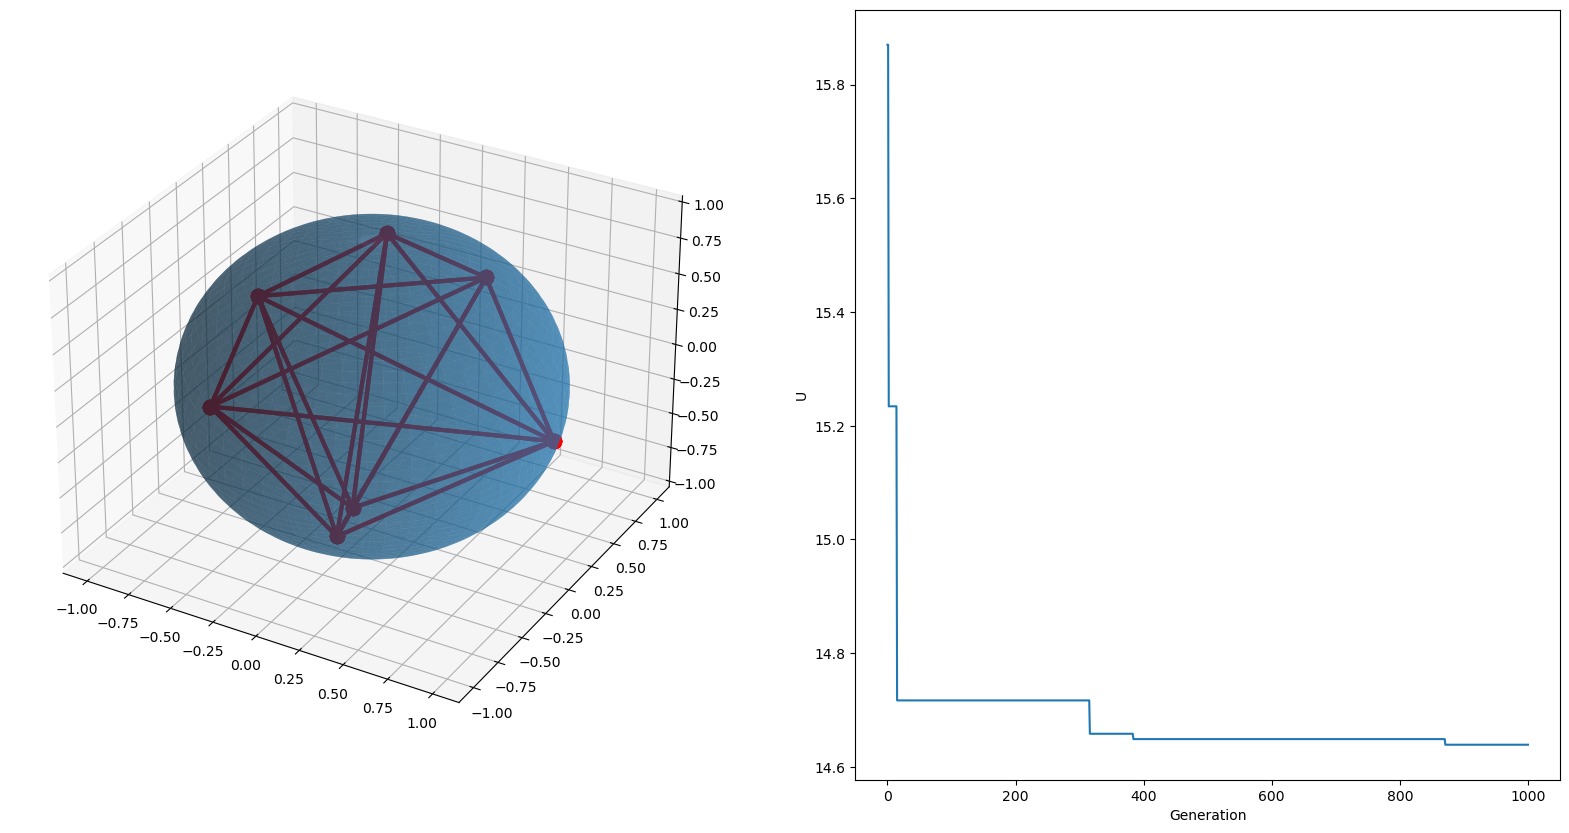

final result for U: 14.638879464306198


In [10]:
tom=GeneticAlgoThompson(24,7,1000)
tom.plot()

print('final result for U:',tom.elite_chromo[-1].fitness)